<a href="https://colab.research.google.com/github/edmenciab733/hackaton2023/blob/main/diagnostico_trastornos_edgar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías 

Se instalan las librerías necesarias
- datasets
- ntlk 
- transformers
- peft


In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q nltk
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dep

Se cargan las librerías necesariás

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import numpy as np
from datasets import load_metric
from transformers import Trainer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import evaluate
from sklearn import metrics
import matplotlib.pyplot as plt

# Dataset
- Se carga stopwords
- Se carga el dataset Sintomas.xlsx
- Se convierte el los padecimientos en una variable númerica llamada Padecimiento_Cat
- Se crean los diccionarios  id2label - label2id para que el pipeline dé los resultados
- Se define el numero de posibles resultados

In [3]:
%%capture
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1EOAx7_OmuKArEo-vM9NaMOXDPVtk3hjOwpcLX4rYnUI/edit#gid=0').sheet1

data = pd.DataFrame.from_records(worksheet.get_all_values())
data.columns = data.iloc[0]
data = data.drop(data.index[0])

In [5]:
data.head()

,Síntoma,Padecimiento
1,"Desde que era joven, ha tenido la creencia de ...",Trastornos de la personalidad esquizotípica
2,Tiene la superstición de que si no sigue ciert...,Trastornos de la personalidad esquizotípica
3,"A menudo experimenta ilusiones corporales, com...",Trastornos de la personalidad esquizotípica
4,"Su discurso a menudo es vago y metafórico, lo ...",Trastornos de la personalidad esquizotípica
5,Tiene la tendencia a pensar que las personas a...,Trastornos de la personalidad esquizotípica


In [6]:
labelencoder = LabelEncoder()
labelencoder.fit(data['Padecimiento'])
data['Padecimiento_Cat'] = labelencoder.transform(data['Padecimiento'])

In [7]:
id2label = {}
label2id = {}
for i in labelencoder.classes_:
   id = labelencoder.transform([i])[0]
   id_aux = str(id)
   id2label[id_aux] = i
   label2id[i] = id_aux

In [8]:
id2label, label2id

({'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'},
 {'Trastornos de la personalidad antisocial': '0',
  'Trastornos de la personalidad borderline': '1',
  'Trastornos de la personalidad esquizotípica': '2',
  'Trastornos de la personalidad histriónica': '3',
  'Trastornos de la personalidad narcisista': '4'})

In [9]:
target_nro = len(labelencoder.classes_)
target_nro

5

In [10]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
1,"Desde que era joven, ha tenido la creencia de ...",Trastornos de la personalidad esquizotípica,2
2,Tiene la superstición de que si no sigue ciert...,Trastornos de la personalidad esquizotípica,2
3,"A menudo experimenta ilusiones corporales, com...",Trastornos de la personalidad esquizotípica,2
4,"Su discurso a menudo es vago y metafórico, lo ...",Trastornos de la personalidad esquizotípica,2
5,Tiene la tendencia a pensar que las personas a...,Trastornos de la personalidad esquizotípica,2


Resumen del balance de los datos

In [11]:
data.Padecimiento.value_counts()

Trastornos de la personalidad borderline       358
Trastornos de la personalidad antisocial       250
Trastornos de la personalidad histriónica      250
Trastornos de la personalidad narcisista       250
Trastornos de la personalidad esquizotípica    225
Name: Padecimiento, dtype: int64

In [12]:
stopwords = set(stopwords.words('spanish'))

In [13]:
import re
def eliminar_acento(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def eliminar_patrones_stopwords(text):
  text = [word for word in text.strip().split() if not word in stopwords]
  text = ' '.join(text)
  return text

def eliminar_espacios_blancos(texto):
    text = re.sub(r"\:|\_", '', texto)
    texto = re.sub(r"\:|\_", '', texto)
    texto = re.sub(r"o\/a", 'o', texto)
    
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto
    
def clean_text(original):
    original = re.sub(r'\w+(?:\.+\w+)*', lambda x: x.group(0).replace('.', ' '), original)
    original = re.sub(r'\.','' , original)

    texto = eliminar_acento(original)
    texto = eliminar_espacios_blancos(texto)
    texto = re.sub(r" +", ' ', texto)
   
    texto = texto.lower()
    texto = eliminar_patrones_stopwords(texto)
    original =  re.sub(r" +", ' ', texto)
    return texto

In [14]:
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
data["Sintoma_Limpia"] = [clean_text(x) for x in data["Síntoma"]]
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat,Sintoma_Limpia
0,Se enoja fácilmente y tiene dificultades para ...,Trastornos de la personalidad borderline,1,enoja facilmente dificultades controlar ira ll...
1,La persona era fácilmente influenciable por lo...,Trastornos de la personalidad histriónica,3,persona facilmente influenciable demas circuns...
2,"Cuando habla, la persona tiende a centrarse en...",Trastornos de la personalidad histriónica,3,habla persona tiende centrarse impresiones qui...
3,Es incapaz de entender los sentimientos y nece...,Trastornos de la personalidad narcisista,4,incapaz entender sentimientos necesidades dema...
4,Ideas paranoides transitorias vinculadas con e...,Trastornos de la personalidad borderline,1,ideas paranoides transitorias vinculadas estre...


Nube de palabras para establecer los usos entender un poco el dataset

In [16]:
def nube_palabras(all_text): 
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                 
                  min_font_size = 10).generate(all_text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

En caso de querer filtrar la nube de palabras reemplazar stopwords_by_cat por el valor deseado. 0, 1, 2,3, 4

{'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'},

In [17]:
def stopwords_by_cat(df, cat):
  df_cat = df.loc[df['Padecimiento_Cat'] == cat]
  all_text = ' '.join(list(df_cat["Sintoma_Limpia"].values))
  return all_text

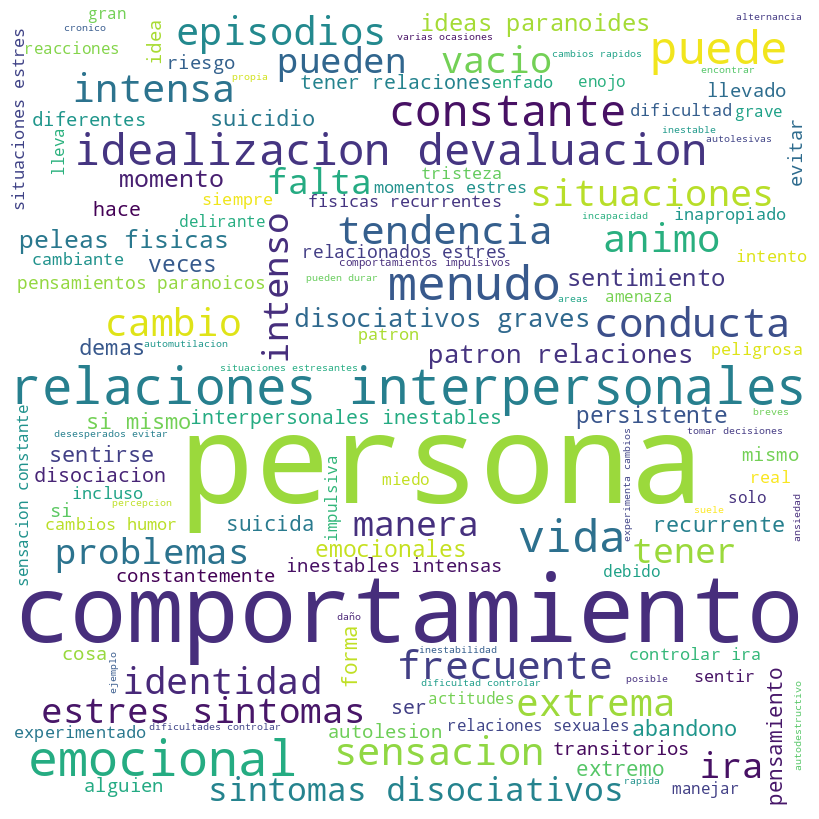

In [18]:
nube_palabras(stopwords_by_cat(data, 1))

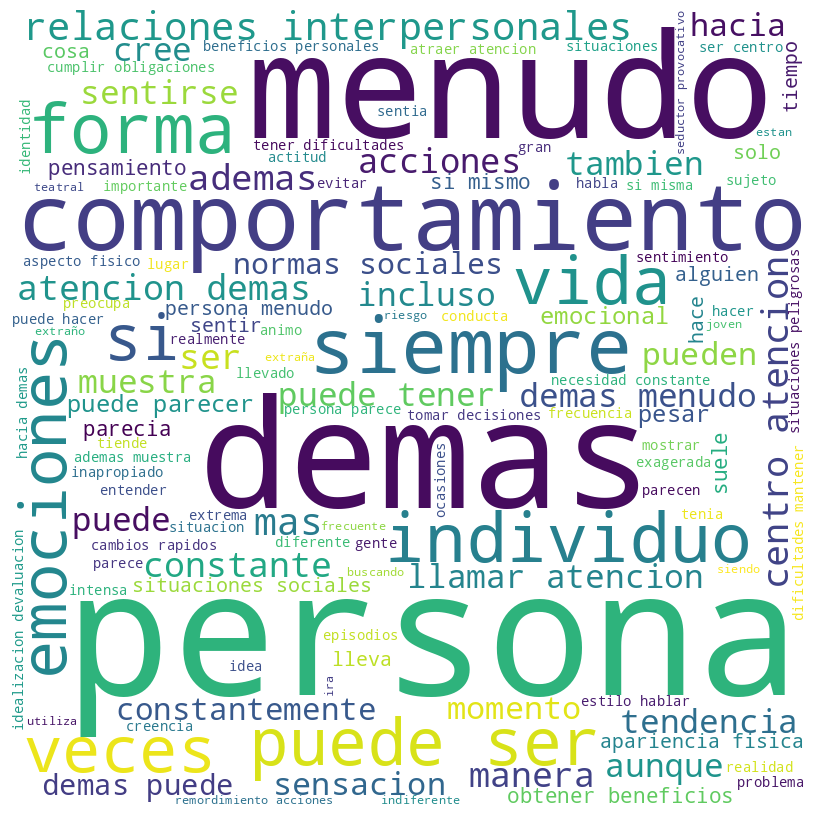

In [19]:
all_text = ' '.join(list(data["Sintoma_Limpia"].values))
nube_palabras(all_text)
del all_text

# FineTuning
- Conversión de pandas a dataset(hugginface)
- Renombre de las columnas adecuedas
- Split train-test de los datos


In [20]:
dataset = Dataset.from_pandas(data)
dataset = dataset.rename_column("Sintoma_Limpia", "text")
dataset = dataset.rename_column("Padecimiento_Cat", "label")

In [21]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['Síntoma', 'Padecimiento', 'label', 'text'],
        num_rows: 1199
    })
    test: Dataset({
        features: ['Síntoma', 'Padecimiento', 'label', 'text'],
        num_rows: 134
    })
})

## Carga de los modelos
-  Carga dccuchile/bert-base-spanish-wwm-cased
-  Preparación de los paramestros de entrenamiento
-  Entrenamiento
-  Guarda de los modelos de entrenamientos


Carga del modelo ber en español

In [22]:
model_id="dccuchile/bert-base-spanish-wwm-cased"
model_id = "xlm-roberta-base"

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [24]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

In [25]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1199 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=target_nro, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [27]:
metric = evaluate.load("accuracy")

In [28]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [29]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [31]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.414882,0.850746
2,No log,0.355764,0.910448
3,No log,0.326474,0.925373


TrainOutput(global_step=450, training_loss=0.5293270874023438, metrics={'train_runtime': 372.2352, 'train_samples_per_second': 9.663, 'train_steps_per_second': 1.209, 'total_flos': 946435958443008.0, 'train_loss': 0.5293270874023438, 'epoch': 3.0})

In [32]:
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.3264739513397217,
 'eval_accuracy': 0.9253731343283582,
 'eval_runtime': 4.108,
 'eval_samples_per_second': 32.619,
 'eval_steps_per_second': 4.138,
 'epoch': 3.0}

In [33]:
index = 1
tokenized_datasets["test"][index]["Síntoma"], tokenized_datasets["test"][index]["label"]

('No tiene amigos íntimos o confidentes fuera de su familia cercana, lo que puede llevarla a sentirse sola o aislada socialmente.',
 2)

In [34]:
predict= trainer.predict(tokenized_datasets["test"])

In [35]:
preds = np.argmax(predict.predictions, axis=-1)

In [36]:
df_evaluate = pd.DataFrame(tokenized_datasets["test"] ) 
df_evaluate['prediction'] = preds

{'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'}


In [37]:
labels = data.Padecimiento_Cat.unique()

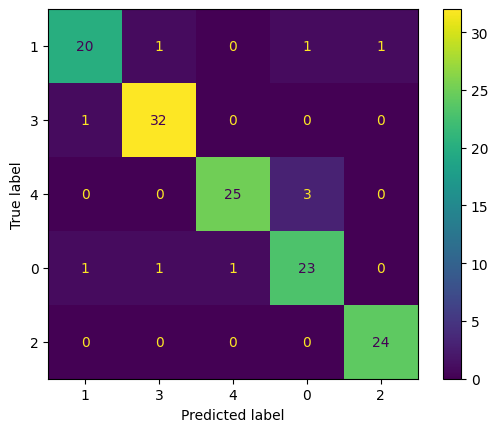

In [38]:
confusion_matrix = metrics.confusion_matrix(df_evaluate['label'], df_evaluate['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

In [39]:
model_id_custom = "./diagnotico_fine_tunning_transformer"
# Save tokenizer
tokenizer.save_pretrained(model_id_custom)
# Save model
trainer.save_model(model_id_custom)

# Testing Model

In [40]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id_custom)
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_id_custom)

In [41]:
from transformers import pipeline

In [42]:
classifier = pipeline("text-classification", model=model_id_custom )

In [43]:
text = ["Gasta más dinero de lo que tiene, a menudo, su falta de control hace que esté en deudas", 
        "Le gusta estar solo y le molesta la gente a su alrededor, solo piensa en él",
        "Tiene pocas habilidades sociales, ignora normas de convivencia", 
        "Siempre que está en falta, culpa a los demás de sus problemas" ]

In [53]:
classifier.model.roberta.embeddings

XLMRobertaEmbeddings(
  (word_embeddings): Embedding(250002, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [44]:
classifier(text)

[{'label': 'Trastornos de la personalidad antisocial',
  'score': 0.9775740504264832},
 {'label': 'Trastornos de la personalidad esquizotípica',
  'score': 0.993783712387085},
 {'label': 'Trastornos de la personalidad antisocial',
  'score': 0.9866369366645813},
 {'label': 'Trastornos de la personalidad borderline',
  'score': 0.850944459438324}]

# XAI Model

In [45]:
%%capture
!pip install captum

In [56]:
import torch
import pandas as pd

from torch import tensor 

from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase

import matplotlib.pyplot as plt

class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs,
                       attention_mask=torch.ones_like(inputs))
        return pred[position]
        
    def visualize(self, inputs: list, attributes: list, prediction: dict):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        a = pd.Series(attr.numpy()[0], 
                         index = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
        
        predicted_label = prediction[0]["label"]

        plt.title(predicted_label)
        
        plt.show(a.plot.barh(figsize=(10,5)))
                      
    def explain(self, text: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline.predict(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, self.__pipeline.model.roberta.embeddings)

        label2id = self.__pipeline.model.config.label2id[prediction[0]['label']] 
        label2id = int(label2id)
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = label2id, 
                                  return_convergence_delta = True)
        
        
        
        self.visualize(inputs, attributes, prediction)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)
    

In [58]:
device = "cpu"
exp_model = ExplainableTransformerPipeline(model_id_custom, classifier, device)

# Upload model

In [48]:
!pip install huggingface_hub -q
!sudo apt-get install git-lfs -q
from huggingface_hub import notebook_login

def push_model_to_hub(dir, name):
  model = AutoModelForSequenceClassification.from_pretrained(dir, 
                                                             num_labels=target_nro, 
                                                             id2label=id2label, 
                                                             label2id=label2id, 
                                                             return_dict=True)
  tokenizer = AutoTokenizer.from_pretrained(dir)

  model.push_to_hub(name, use_temp_dir=True)
  tokenizer.push_to_hub(name, use_temp_dir=True)

#!huggingface-cli login
#notebook_login()
#push_model_to_hub('./diagnotico_fine_tunning_transformer', 'hackathon-somos-nlp-2023/DiagTrast')

ERROR: Operation cancelled by user
Reading package lists...
Building dependency tree...
Reading state information...
git-lfs is already the newest version (2.9.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


# Tests

In [49]:
texto = data.iloc[4]['Síntoma']
texto

'Ideas paranoides transitorias vinculadas con el estrés o síntomas disociativos severos.'

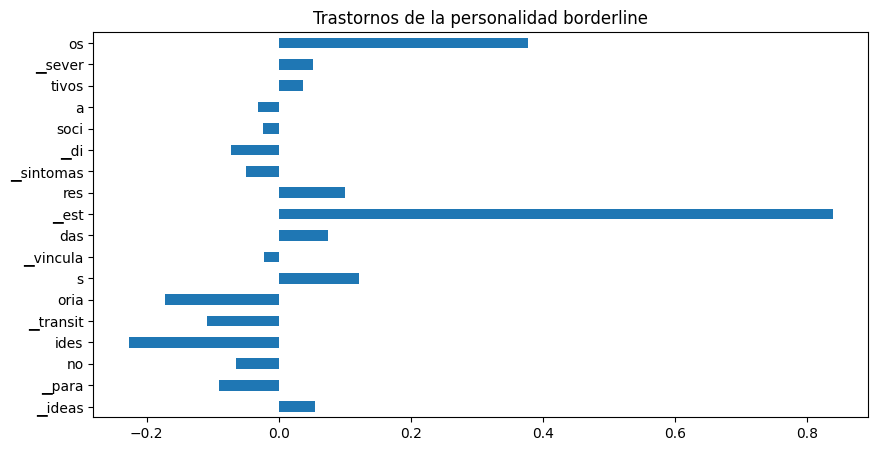

In [59]:
sample = clean_text(texto)
exp_model.explain(sample)

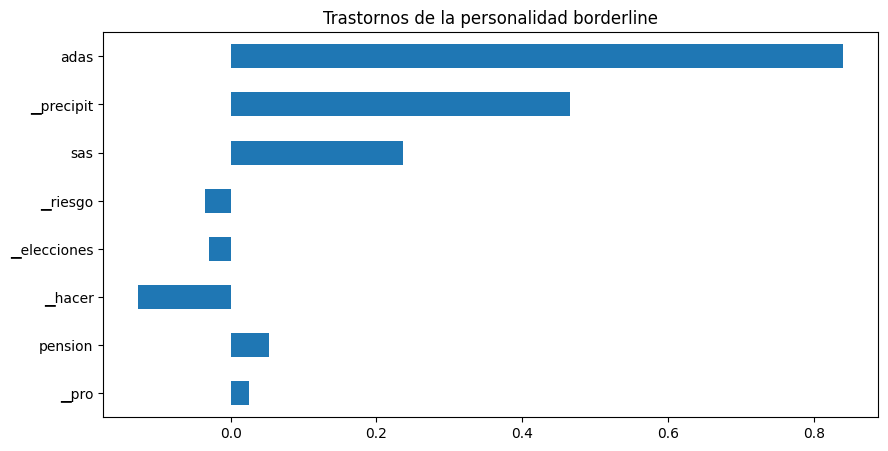

In [60]:
texto2 = 'Propensión a hacer elecciones riesgosas y precipitadas.'
exp_model.explain(clean_text(texto2))

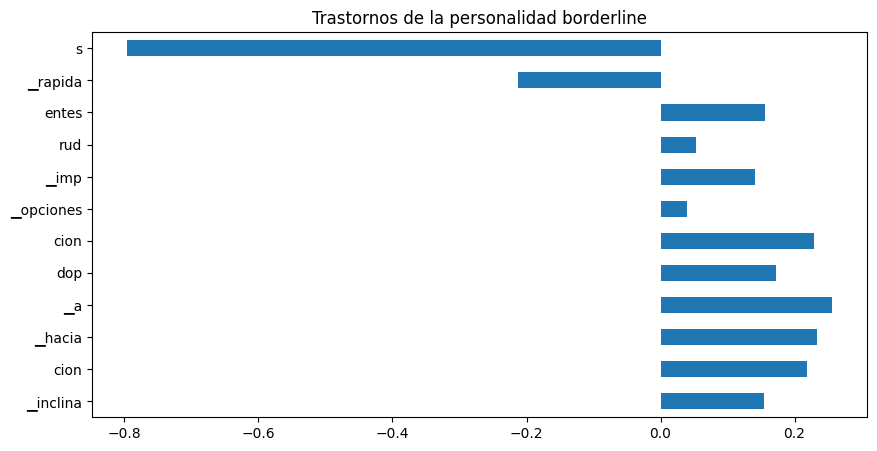

In [61]:
texto3 = 'Inclinación hacia la adopción de opciones imprudentes y rápidas.'
exp_model.explain(clean_text(texto3))

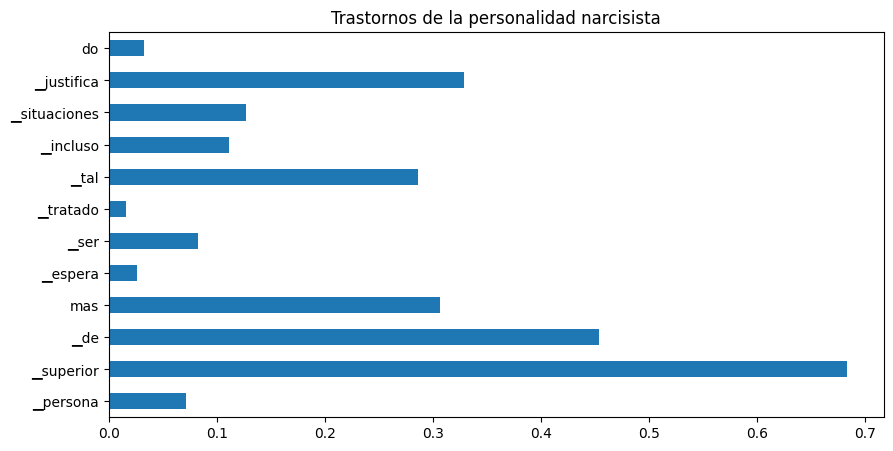

In [62]:
texto4 = 'Esta persona se siente superior a los demás y espera ser tratado como tal, incluso en situaciones donde no es justificado.'
exp_model.explain(clean_text(texto4))

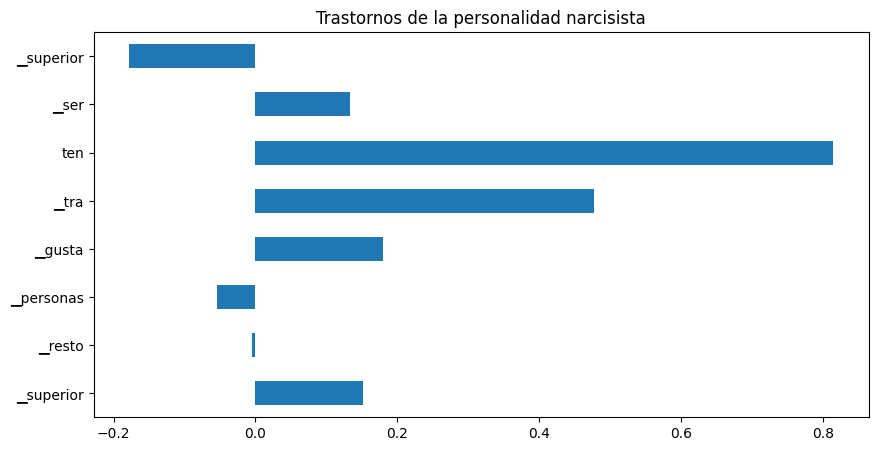

In [63]:
texto5 = 'Soy superior al resto de las personas y me gusta que me tratén como ser superior.'
exp_model.explain(clean_text(texto5))

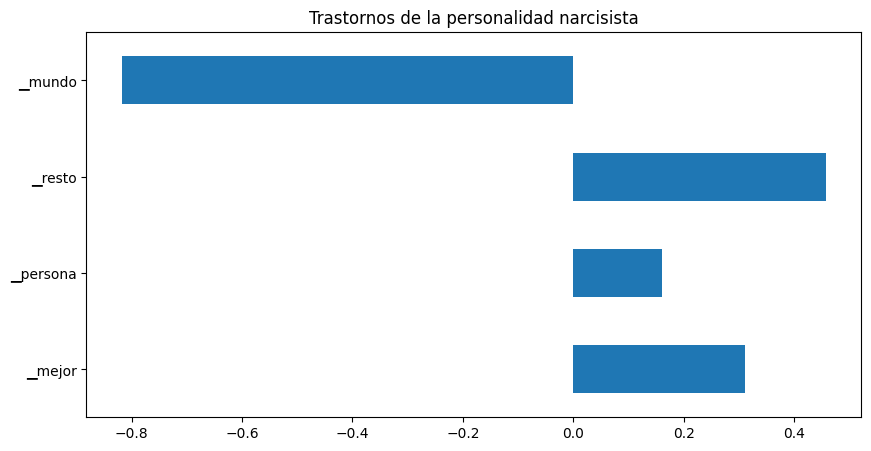

In [64]:
texto7 = 'Soy mejor persona que el resto del mundo'
exp_model.explain(clean_text(texto7))

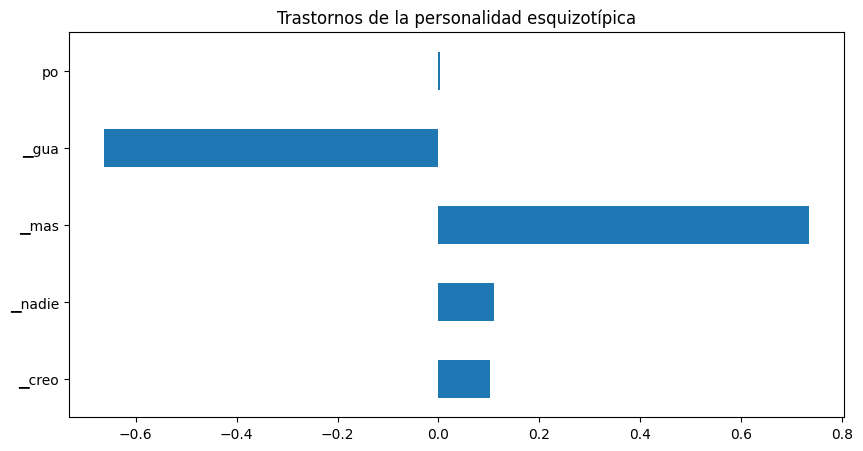

In [65]:
texto8 = 'Creo que no hay nadie más guapo que yo'
exp_model.explain(clean_text(texto8))

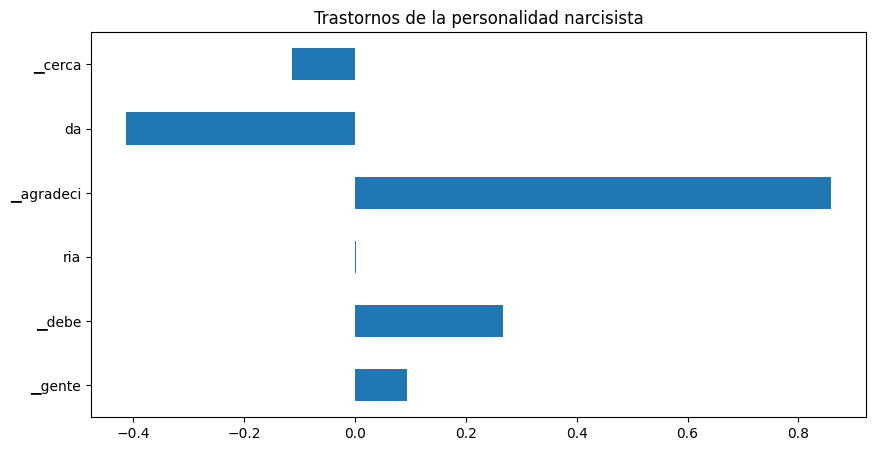

In [66]:
texto9 = 'La gente debería estar agradecida de estar cerca de mí'
exp_model.explain(clean_text(texto9))

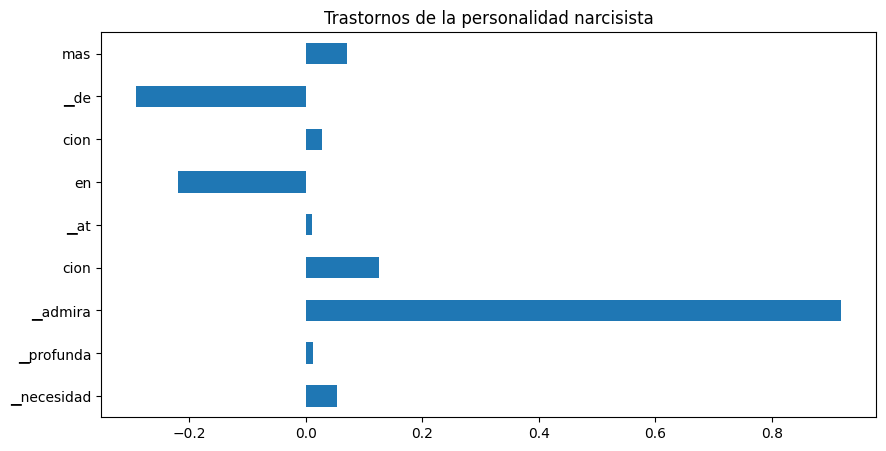

In [68]:
texto10 = 'Tiene una necesidad profunda de admiracion y atención por los demas'
exp_model.explain(clean_text(texto10))

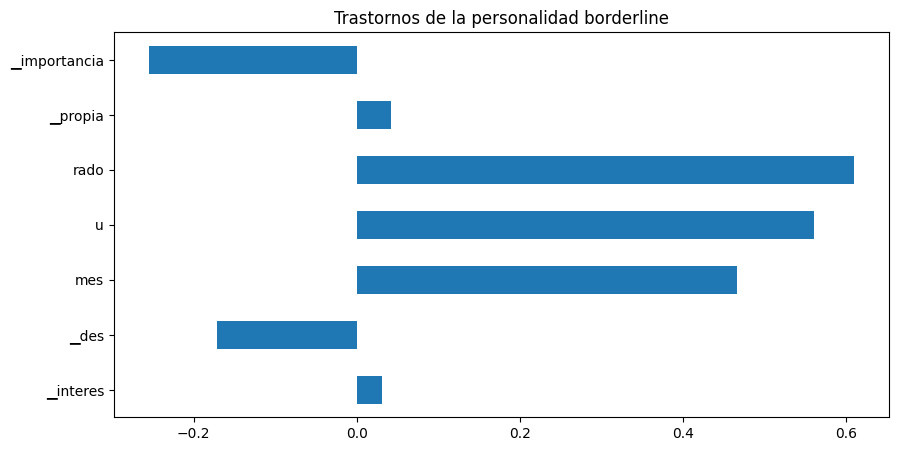

In [71]:
texto11 = 'Tiene un interes desmesurado de su propia importancia'
exp_model.explain(clean_text(texto11))